In [1]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from infowavegan import WaveGANQNetwork
from torch.utils.data import DataLoader
import glob
import os
from scipy.io.wavfile import read
import librosa
from IPython.display import Audio, display
import train_Q2_TD
import q_dev_fns

In [2]:
NUM_CATEG = 11
SLICE_LEN = 16384
device="cuda"
LEARNING_RATE = 1e-4
timit_words = "she had your suit in dark greasy wash water all year".split(' ')+['UNK']
datadir = "/home/stephan/notebooks/talker_variability/TIMIT_padded/"
BATCH_SIZE = 192
start_epoch = 0
start_step = 0
NUM_EPOCHS = 25

In [3]:
Q = WaveGANQNetwork(slice_len=SLICE_LEN, num_categ=NUM_CATEG).to(device).train()
optimizer_Q_to_Q = optim.RMSprop(Q.parameters(), lr=LEARNING_RATE)
criterion_Q = lambda inpt, target: torch.nn.CrossEntropyLoss()(inpt, target.max(dim=1)[1])

In [4]:
# start a dataloader with the Q network
dataset = train_Q2_TD.AudioDataSet(datadir, SLICE_LEN, NUM_CATEG, timit_words)
dataloader = DataLoader(
    dataset,
    BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    drop_last=True
)

Loading data


100%|██████████| 5082/5082 [00:01<00:00, 3825.80it/s]


In [5]:
regenerate = False
if regenerate:
    step = start_step
    for epoch in range(start_epoch + 1, NUM_EPOCHS):
        print("Epoch {} of {}".format(epoch, NUM_EPOCHS))
        print("-----------------------------------------")

        pbar = tqdm(dataloader)            
        for i, trial in enumerate(pbar):            
            reals = trial[0].to(device)
            labels = trial[1].to(device)        
            optimizer_Q_to_Q.zero_grad()
            adult_recovers_from_adult = Q(reals)    
            Q_comprehension_loss = criterion_Q(adult_recovers_from_adult, labels[:,0:NUM_CATEG]) # Note we exclude the UNK label --  child never intends to produce unk
            print(Q_comprehension_loss)
            Q_comprehension_loss.backward()
            optimizer_Q_to_Q.step()
            step += 1
    torch.save(Q, 'saved_networks/adult_pretrained_Q_network.torch')
else:
    Q = torch.load('saved_networks/adult_pretrained_Q_network.torch')
    Q.eval()
    
# freeze it
for p in Q.parameters():
    p.requires_grad = True

In [6]:
Q = torch.load('saved_networks/adult_pretrained_Q_network.torch')
Q = Q.eval()

# Run the Adult Q network on a new dataset

In [37]:
# Directory from a network that hasn't elarned the word-to-referent mapping
test_folder = '/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/'
X, Y, filenames  = q_dev_fns.load_wavs_and_labels(test_folder, SLICE_LEN, NUM_CATEG, device, timit_words)
Q_vals = torch.nn.Softmax(dim=1)(Q(X))

100%|██████████| 132/132 [00:00<00:00, 4211.73it/s]


In [48]:
q_dev_fns.evaluate_asr_system(Q_vals, Y, device, timit_words, filenames)

> /home/stephan/notebooks/ciwganfiwgan-pytorch/q_dev_fns.py(60)evaluate_asr_system()
     58     import pdb
     59     pdb.set_trace()
---> 60     rdf = pd.DataFrame({
     61         "human label":[timit_words[x] for x in torch.argmax(Y[failures,:], dim=1).detach().cpu().numpy()],
     62         "asr system label":[timit_words[x] for x in highest_prob_from_asr[failures,].detach().cpu().numpy()],



ipdb>  [timit_words[x] for x in highest_prob_from_asr[failures,].detach().cpu().numpy()]


*** NameError: name 'timit_words' is not defined


ipdb>  np.array(filenames)[failures.detach().cpu().numpy()]


array([['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/suit_66f3f229-1514-499c-a703-2647b32166db.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/had_d6ca00bd-77aa-4de2-974b-da3655dc40a5.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/greasy_730630d8-023e-4c73-8532-bef8c5fef47d.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/greasy_0a114ed6-71c1-4c79-83b4-60a4350007ba.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/dark_106f1a00-0e0d-4198-afcb-9fcc994e28fe.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/your_00b4884d-a984-4619-baf1-ad4498270f66.wav'],
       ['/home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001/year_42fa50d1-7d30-4476-b007-39ee6be29c5f.wav

ipdb>  entropy.detach().cpu().numpy()


array([8.3105604e-04, 1.0552123e-01, 1.9722385e-02, 1.8919653e-03,
       1.8312564e-01, 1.1843285e-01, 3.3941832e-01, 5.7909605e-03,
       9.5785677e-04, 4.5949817e-01, 2.0801069e-03, 4.4921562e-02,
       7.8311890e-02, 3.4640680e-06, 5.0858699e-02, 5.6081202e-02,
       3.9788924e-02, 6.8964696e-01, 1.8066065e-02, 2.8742902e-02,
       3.5138275e-02, 7.4596864e-01, 4.1039228e-01, 4.5483431e-04,
       8.5786216e-02, 9.9896395e-01, 3.7284564e-05, 1.1278809e-01,
       1.7858491e-03, 9.1813179e-03, 3.9337134e-05, 3.5220095e-05,
       3.1331316e-01, 4.2141496e-06, 1.0316052e-03, 1.1680208e+00,
       6.3663017e-04, 7.8496721e-04, 3.5701430e-01, 2.5333991e-02,
       5.3363729e-01, 1.5182777e-01, 9.2403844e-02, 3.7816335e-05,
       4.8999971e-01, 3.6573064e-01, 8.5303652e-01, 6.6162261e-06,
       5.9300037e-03, 2.1020963e-04, 1.5397066e-01, 2.9519826e-01,
       1.1612479e-01, 6.1184406e-01, 5.1258969e-01, 9.6425533e-01,
       3.2161757e-01, 4.6137295e-04, 3.8216240e-07, 8.6722357e

ipdb>  matches.detach().cpu().numpy()


array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
        True,  True, False, False,  True, False, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
        True,  True,  True, False, False,  True, False, False,  True,
       False, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
        True,  True,  True, False, False,  True,  True,  True, False,
       False, False,

ipdb>  [timit_words[x] for x in highest_prob_from_asr[failures,].detach().cpu().numpy()]


*** NameError: name 'timit_words' is not defined


ipdb>  timit_words


array(['she', 'had', 'your', 'suit', 'in', 'dark', 'greasy', 'wash',
       'water', 'all', 'year', 'UNK'], dtype='<U6')


ipdb>  quit()


In [220]:
# Directory with hand-labeled data
test_folder = '/home/stephan/notebooks/ciwganfiwgan-pytorch/q2_dev_data/2001_relabeled/'
X, Y, filenames  = q_dev_fns.load_wavs_and_labels(test_folder, SLICE_LEN, NUM_CATEG, device, timit_words)
Q_vals = torch.nn.Softmax(dim=1)(Q(X))

100%|██████████| 133/133 [00:00<00:00, 4147.87it/s]


In [221]:
Q_vals.shape

torch.Size([133, 11])

In [233]:
import imp
imp.reload(q_dev_fns)
Q_vals_with_unks = q_dev_fns.mark_unks_in_Q(Q_vals, .1, device)

In [234]:
Qnetwork_results = q_dev_fns.evaluate_asr_system(Q_vals_with_unks, Y, device, timit_words, filenames)
Qnetwork_results

{'df':     human label asr system label  matches   
 0          suit             suit     True  \
 1           UNK             your    False   
 2           UNK              UNK     True   
 3           all              all     True   
 4           UNK              UNK     True   
 ..          ...              ...      ...   
 128         UNK              UNK     True   
 129        your             your     True   
 130        your              UNK    False   
 131      greasy           greasy     True   
 132         UNK              all    False   
 
                                              filenames   entropy  recognized  
 0    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...  0.000930        True  
 1    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...  0.040710       False  
 2    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...  0.010132        True  
 3    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...  0.003001        True  
 4    /home/stephan/notebooks/ciwganfiwg

# Entropy Threshold

In [106]:
%reload_ext rpy2.ipython
%R library('ggplot2')
%R library('pROC')

R[write to console]: Need help? Try Stackoverflow: https://stackoverflow.com/tags/ggplot2

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var




array(['pROC', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [109]:
qnr =  Qnetwork_results['df']
%R -i qnr
%R head(qnr)

,human label,asr system label,matches,filenames,entropy,recognized
0,suit,suit,True,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.000009,True
1,UNK,your,False,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.039789,False
2,UNK,your,False,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.645289,False
3,all,all,True,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.002080,True
4,UNK,had,False,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.709444,False
5,suit,suit,True,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,0.000004,True


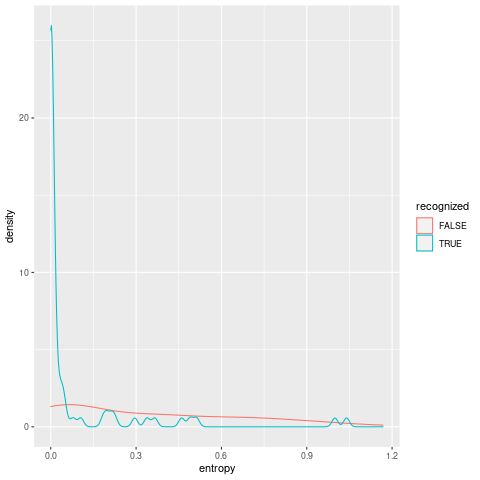

In [110]:
%%R
ggplot(qnr) + geom_density(aes(x=entropy, color = recognized))

In [116]:
%%R
library('plotROC')

R[write to console]: 
Attaching package: ‘plotROC’


R[write to console]: The following object is masked from ‘package:pROC’:

    ggroc




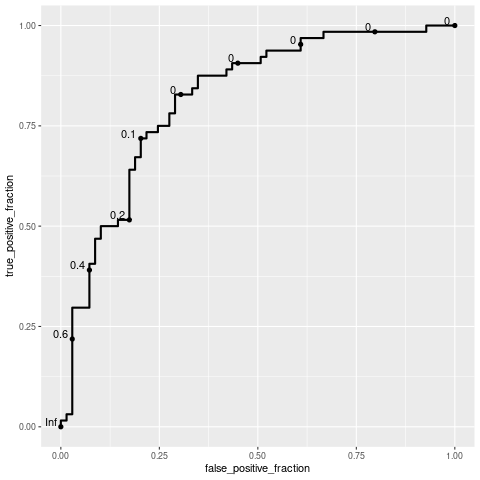

In [118]:
%%R
ggplot(qnr, aes(m = entropy, d = -1*recognized)) + geom_roc()

# Error analysis on the Q network failures

In [12]:
# inspect a single file
q_dev_fns.inpsect_failure(Qnetwork_results, 1)

Mistmatch in: /home/stephan/notebooks/ciwganfiwgan-pytorch/run_log/12_TD_2000+_batchedQupdate/2001_relabeled/all_keep_2cb4c41a-044a-4449-9acd-db6acbfcf1db.wav
Q index expects: had
Human labeled: all


4, Q network is just wrong  
5, Q network is wrong, but it's ambiguous  
13, in vs. your -- similar production to #4  
16, Q network is wrong  
17, Q network is just wrong  
20, Q network is just wrong  
26, Q network is just wrong  
27, ambigous -- year and in at the same time  
31, Q network is wrong  
44, Q network is wrong   
49, Q netwrok is wrong  
66, Q netwrok is wrong, but slightly weird water   
74, Q netwrok is wrong, but slightly weird water   
76, ambiguous between year and in  
78, Q netwrok is wrong  

# Error Analysis on the Whisper Failures

In [235]:
import imp
imp.reload(train_Q2_TD)

<module 'train_Q2_TD' from '/home/stephan/notebooks/ciwganfiwgan-pytorch/train_Q2_TD.py'>

In [236]:
import faster_whisper
vocab = pd.read_csv('data/vocab.csv')
vocab = vocab.loc[vocab['count'] > 20]

# Method 1: upweight proportionately
#vocab.loc[vocab.word.isin(timit_words),'count'] = 100000. * vocab.loc[vocab.word.isin(timit_words)]['count']
#vocab['probability'] = vocab['count'] / np.sum(vocab['count'])

# Method 2: uniform over timit words, with remaining words divided
prob_to_give_to_timit_words = .8
vocab['upweighted_prob'] = 0
vocab.loc[vocab.word.isin(timit_words) ,'upweighted_prob'] = prob_to_give_to_timit_words / len(timit_words)
vocab['base_probability'] = (vocab['count'] / np.sum(vocab['count'])) * (1. - prob_to_give_to_timit_words)
vocab['probability'] = vocab['base_probability'] + vocab['upweighted_prob']


vocab.word = vocab.word.astype('str')
fast_whisper_model = faster_whisper.WhisperModel('medium.en', device="cuda", compute_type="float16")
Q2_GLOBALS = {
        "MIN_DECODING_PROB" : .1,
        "MAX_NOSPEECH_PROB" : .1,
        "MAX_UNK_PROB" : .5, # this was .2
        "Q2_TIMEOUT" : 2
    }

In [237]:
vocab.loc[vocab.word == 'greasy']

,Unnamed: 0,word,count,upweighted_prob,base_probability,probability
6299,6299,greasy,48,0.066667,6.500401e-07,0.066667


In [238]:
indices_of_recognized_words, Q2_probs, filenames, whisper_recognition_info = train_Q2_TD.Q2_whisper(
    X[:,0,:], Y, fast_whisper_model, timit_words, vocab, -1, Q2_GLOBALS, write_only=False)

100%|██████████| 133/133 [02:08<00:00,  1.04it/s]


In [239]:
whisper_results = q_dev_fns.evaluate_asr_system(torch.from_numpy(Q2_probs).to(device), Y, device, timit_words, filenames)
whisper_results

{'df':     human label asr system label  matches   
 0          suit              she    False  \
 1           UNK               in    False   
 2           UNK              UNK     True   
 3           all             dark    False   
 4           UNK             suit    False   
 ..          ...              ...      ...   
 128         UNK              UNK     True   
 129        your              had    False   
 130        your               in    False   
 131      greasy           greasy     True   
 132         UNK              all    False   
 
                                              filenames   entropy  recognized  
 0    temp/-1/suit_508356cb-0f4b-4a31-9198-854417929...  1.900701       False  
 1    temp/-1/UNK_a2ff1f3a-5dd1-4313-a1b7-803863be14...  1.585936       False  
 2    temp/-1/UNK_2303da15-439b-4abb-85cb-7ad7ce11ac...       NaN        True  
 3    temp/-1/all_bd018d29-7835-4b3b-bb31-e97a495c4a...  1.696638       False  
 4    temp/-1/UNK_e1c3d0e6-b3cf-4777-ba5

In [240]:
# inspect a single file
q_dev_fns.inpsect_failure(whisper_results, 1)

Mistmatch in: temp/-1/UNK_a2ff1f3a-5dd1-4313-a1b7-803863be1456.wav
Q index expects: in
Human labeled: UNK


# Todos

In [24]:
# [X] Error analysis -- which words is this bad at? Years and yours, remapping a lot of them to IN
# [X] compare with the quality of the output of whisper -- whisper is never wrong about the identity, 
# but it over-assigns the UNKs. So maybe it isn't interevening early enough
# [ ] Performance in the adult Q network is bad, but is it okay that it is this errorful?     
   # [ ] Could figure out a way to train it on other intermediate productions -- eg use WHISPER 
    # to identify a bunch of intermediate and noisy candidates; then this netowrk will be fast

# there should be no UNKs in this set

    

# [ ] could try fiddling with the params in whisper -- but this is too slow to operate from the beginning    
# [ ] How to handle uncertainty in the Q network -- the recongition performance depends on how we pick out UNKs 
    # Entropy based cirterion
    # give it a 12th category of UNK

    
    


# [ ] This means we can do early intervention with the frozen Q network
# [ ] THis means we might have a submission for the 28th
# [ ] consider VAD

# Adding Unks to the Test Set

In [100]:
raise ValueError("Don't run this part automatically -- should jsut need to happen once")

ValueError: Don't run this part automatically -- should jsut need to happen once

In [83]:
wavs = pd.DataFrame({'filename': glob.glob('/home/stephan/notebooks/ciwganfiwgan-pytorch/q2_dev_data/2001_relabeled/*.wav')
})
wavs['basename'] = [os.path.basename(x) for x in wavs.filename]
wavs['uuid'] = [x.replace('.wav','').split('_')[-1] for x in  wavs['basename']]
wavs['word']= [x.replace('.wav','').split('_')[0] for x in  wavs['basename']]
wavs['keep']= ['_keep_' in x for x in wavs['basename']]
wavs

,filename,basename,uuid,word,keep
0,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,suit_keep_0572dab6-eddc-4b9c-983e-7bc9b49c0ad5...,0572dab6-eddc-4b9c-983e-7bc9b49c0ad5,suit,True
1,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,greasy_730630d8-023e-4c73-8532-bef8c5fef47d.wav,730630d8-023e-4c73-8532-bef8c5fef47d,greasy,False
2,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,all_keep_88711fa2-d2bd-406b-b49f-4b11d5d5f185.wav,88711fa2-d2bd-406b-b49f-4b11d5d5f185,all,True
3,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,suit_keep_3d7d80cd-9a72-452c-b6c3-7e56c9f33cce...,3d7d80cd-9a72-452c-b6c3-7e56c9f33cce,suit,True
4,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,greasy_keep_4c10d97e-759b-4980-ba6b-665b3ac869...,4c10d97e-759b-4980-ba6b-665b3ac8692b,greasy,True
...,...,...,...,...,...
128,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,year_a14c7c7c-316f-40d8-9e16-664fd480fd40.wav,a14c7c7c-316f-40d8-9e16-664fd480fd40,year,False
129,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,all_cf294927-5a3d-488d-835a-64557c6bcc4b.wav,cf294927-5a3d-488d-835a-64557c6bcc4b,all,False
130,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,your_keep_c79ac64b-353b-499c-9a0e-7bc4d97052b1...,c79ac64b-353b-499c-9a0e-7bc4d97052b1,your,True
131,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,greasy_keep_22f26c9a-78fa-4f04-afb1-376480236d...,22f26c9a-78fa-4f04-afb1-376480236d5c,greasy,True


In [85]:
print(wavs.shape)
keeps = wavs.loc[wavs.keep]
print(keeps.shape)
originals = wavs.loc[~wavs.keep]
unks = originals.loc[~originals.uuid.isin(keeps.uuid)]
print(unks.shape)

(133, 5)
(79, 5)
(54, 5)


In [88]:
unks.head(5)

,filename,basename,uuid,word,keep,new_word
1,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,greasy_730630d8-023e-4c73-8532-bef8c5fef47d.wav,730630d8-023e-4c73-8532-bef8c5fef47d,greasy,False,UNK
6,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,your_00b4884d-a984-4619-baf1-ad4498270f66.wav,00b4884d-a984-4619-baf1-ad4498270f66,your,False,UNK
10,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,she_b0615960-d724-4f41-8c1b-045cdb589709.wav,b0615960-d724-4f41-8c1b-045cdb589709,she,False,UNK
12,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,greasy_76593767-0265-4947-b88e-dffd1e6c7cef.wav,76593767-0265-4947-b88e-dffd1e6c7cef,greasy,False,UNK
13,/home/stephan/notebooks/ciwganfiwgan-pytorch/q...,year_2ec52e94-fce8-44ad-ba64-9b4cc24920df.wav,2ec52e94-fce8-44ad-ba64-9b4cc24920df,year,False,UNK


In [98]:
import shutil

In [99]:
# rename the UNKS as such
unks['new_word'] = 'UNK'
unks['new_basename'] = unks['new_word'].map(str)+'_keep_'+unks['uuid'].map(str)+'.wav'
directory = os.path.dirname(unks.iloc[0]['filename'])
unks['new_filename'] = [os.path.join(directory, x) for x in  unks['new_basename']]
unks.iloc[0].new_filename

[os.rename(x['filename'], x['new_filename']) for x in unks.to_dict('records')] 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [77]:
# delete the ontes that ar in keeps
redundant_files= originals.loc[originals.uuid.isin(keeps.uuid)]

In [80]:
redundant_files.filename

0      /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
1      /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
5      /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
9      /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
12     /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
                             ...                        
189    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
193    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
196    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
201    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
209    /home/stephan/notebooks/ciwganfiwgan-pytorch/q...
Name: filename, Length: 79, dtype: object

In [81]:
[os.remove(x) for x in redundant_files.filename]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]